In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
# import warnings
# warnings.filterwarnings("ignore") # suppress warning

np.random.seed(1996)

df = pd.read_csv("dataset/zoo.csv")
df_class = pd.read_csv("dataset/class.csv")

Si prende in esame il dataset di uno zoo. L'obbiettivo è implementare un modello che permetta di predirre correttamente il `class_type`:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   animal_name  101 non-null    object
 1   hair         101 non-null    int64 
 2   feathers     101 non-null    int64 
 3   eggs         101 non-null    int64 
 4   milk         101 non-null    int64 
 5   airborne     101 non-null    int64 
 6   aquatic      101 non-null    int64 
 7   predator     101 non-null    int64 
 8   toothed      101 non-null    int64 
 9   backbone     101 non-null    int64 
 10  breathes     101 non-null    int64 
 11  venomous     101 non-null    int64 
 12  fins         101 non-null    int64 
 13  legs         101 non-null    int64 
 14  tail         101 non-null    int64 
 15  domestic     101 non-null    int64 
 16  catsize      101 non-null    int64 
 17  class_type   101 non-null    int64 
dtypes: int64(17), object(1)
memory usage: 14.3+ KB


Data la presenza di molti attributi visualizzo la heatmap per eliminare i valori con indice più basso.<br>
La heatmap è un metodo grafico per visualizzare la matrice di correlazione di dati k-dimensionali su tutte le variabili.<br>
In statistica la correlazione è una relazione tale che i valori assunti da una variabile corrispondono ad una certa regolarità ai valori assunti da un'altra. I valori:
- superiori a 0.5 indicano una buona correlazione positiva
- inferiori a -0.5 indicano una buona correlazione negativia
- prossimi a 1 indicano una forte correlazione positiva
- prossimi a -1 indicano una forte correlazione negativa
<br><br>
Inoltre: un indice positivo induvidua un andamento ascendente nello scatterplot (retta con coeff. angolare positivo), un indice negativo individua un andamento discendente (retta con coeff. angolare negativo). Il valore assoluto dell'indice è la larghezza del corridoio formato dai dati.

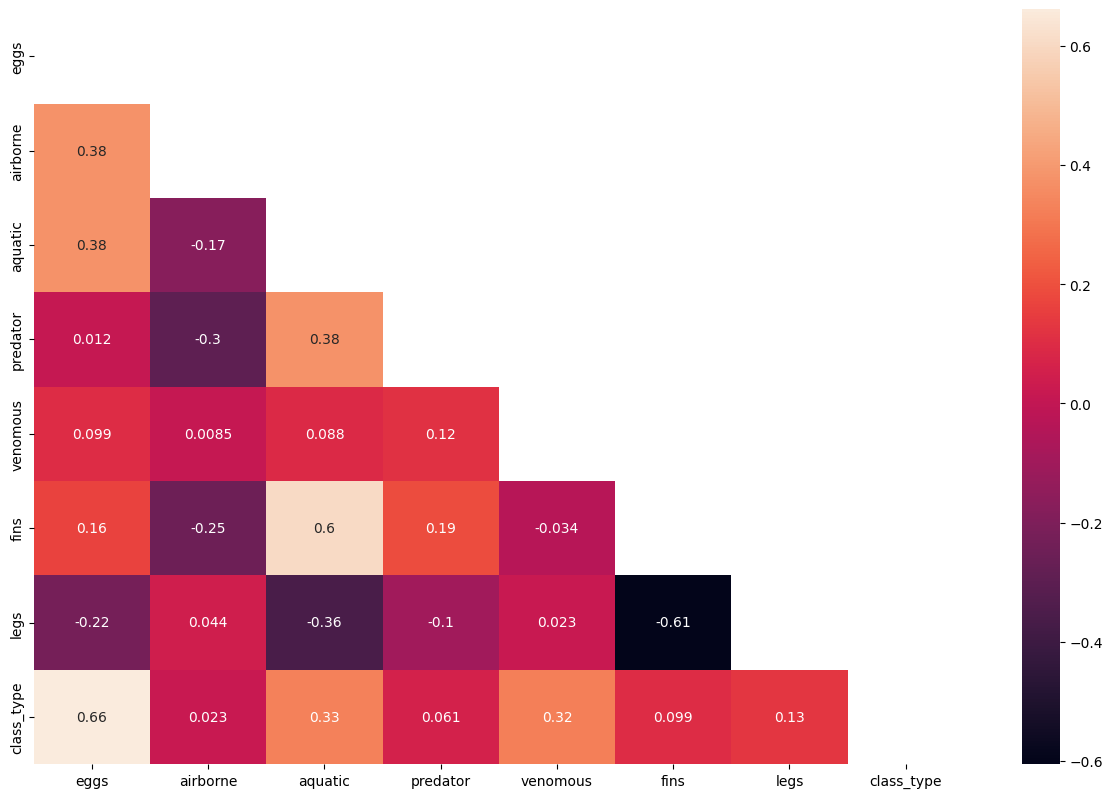

In [34]:
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

# plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':100})
# sns.heatmap(df.corr(), annot=True, mask=mask)
# plt.show()

In [12]:
df.drop(columns=['hair', 'feathers', 'milk', 'toothed', 'backbone', 'breathes', 'tail', 'domestic', 'catsize'], inplace=True)

Per ottenere la probabilità che un dato elemento cada in una delle 7 classi disponibili, mi costruisco dunque una Probability Mass Function per ragionare in termini probabilistici (divido le frequenze per il numero di osservazioni presenti nel campione) che deve, inoltre, obbedire alle due regole:
$$0 \leqslant f(x_i) \leqslant 1 \:\:\:\: \forall i = 1,...,N$$
$$\sum_{i}^{N} f(x_i) = 1$$


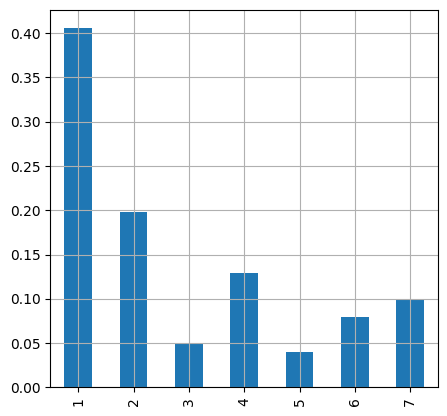

In [23]:
plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})
df['class_type'].value_counts(normalize=True).sort_index().plot.bar()
plt.grid(True)
plt.show()

Per completezza calcolo la Cumulative Distributy Function che mappa un valore del campione al relativo
ordine di quartile (è utile quando si vogliono mettere a confronto due distribuzioni per verificare che obbediscano alle stesse regole):

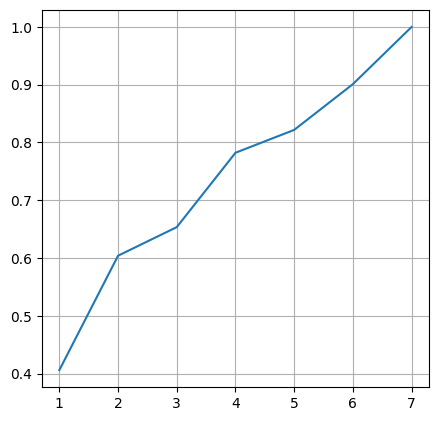

In [25]:
cdf_classtype = df["class_type"].value_counts(normalize=True).sort_index().cumsum()
plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})
plt.plot(cdf_classtype.index, cdf_classtype.values)
plt.grid()
plt.show()

È più opportuno conoscere la Probability Density Function di un campione (analogo della PMF ma con con variabile di riferimento continua invece di discreta). Questo passaggio permette di descrivere meglio il fenomeno e ridurre l'influenza del rumore dovuto alle rilevazioni. Prima di plottare la distribuzione mi ricavo il numero di Sturges e Rice. 

La regola di Sturges serve per determinare il numero di classi che devono esistere in un istogramma delle frequenze al fine di classificare un insieme di dati che rappresentano il campione o una popolazione (determina la lunghezza). In particolare il numero di bin secondo la regola di sturges è uguale a 

$$ bin = 3.3 log N $$

con N numero di osservazioni

Come alternativa si può calcolare anche tramite la regola di Rice:

$$ k = 2 \sqrt[3]n $$

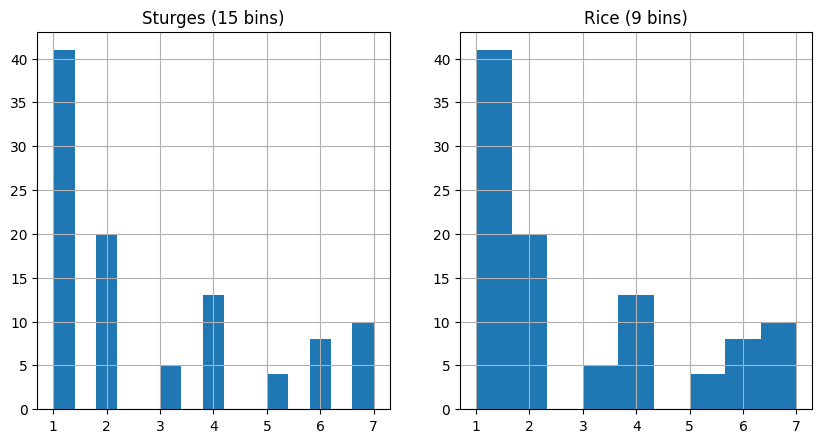

In [18]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':100})
values, edges, _ = plt.hist(df["class_type"])

sturges=int(3.3*np.log(len(df["class_type"])))
rice=int(2*len(df["class_type"])**(1/3))

plt.subplot(1,2,1)
plt.title('Sturges ({} bins)'.format(sturges))
plt.hist(df["class_type"], bins=sturges)
plt.grid()
plt.subplot(1,2,2)
plt.title('Rice ({} bins)'.format(rice))
plt.grid()
plt.hist(df["class_type"], bins=rice)
plt.show()

Voglio realizzare un modello che predica `class_type`. Visualizzo la distribuzione con l'istogramma delle frequenze utilizzando il parametro `density=True`. Plotto anche una stima della densità e la confronto con l'istogramma.

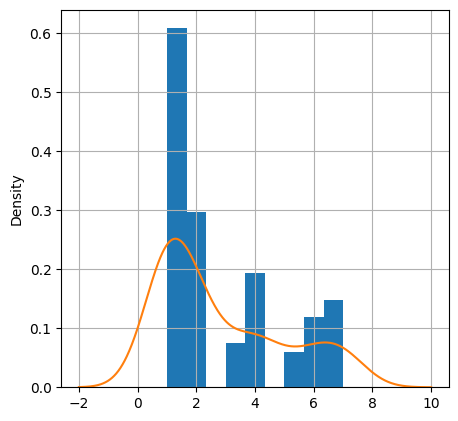

In [26]:
plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})
df['class_type'].plot.hist(bins=rice, density=True) # è equivalente adf['class_type'].max() / len(df['class_type'])
df['class_type'].plot.density()
plt.grid(True)
plt.show()

Mi avvalgo del pairplot per vedere le correlazioni tra gli attributi

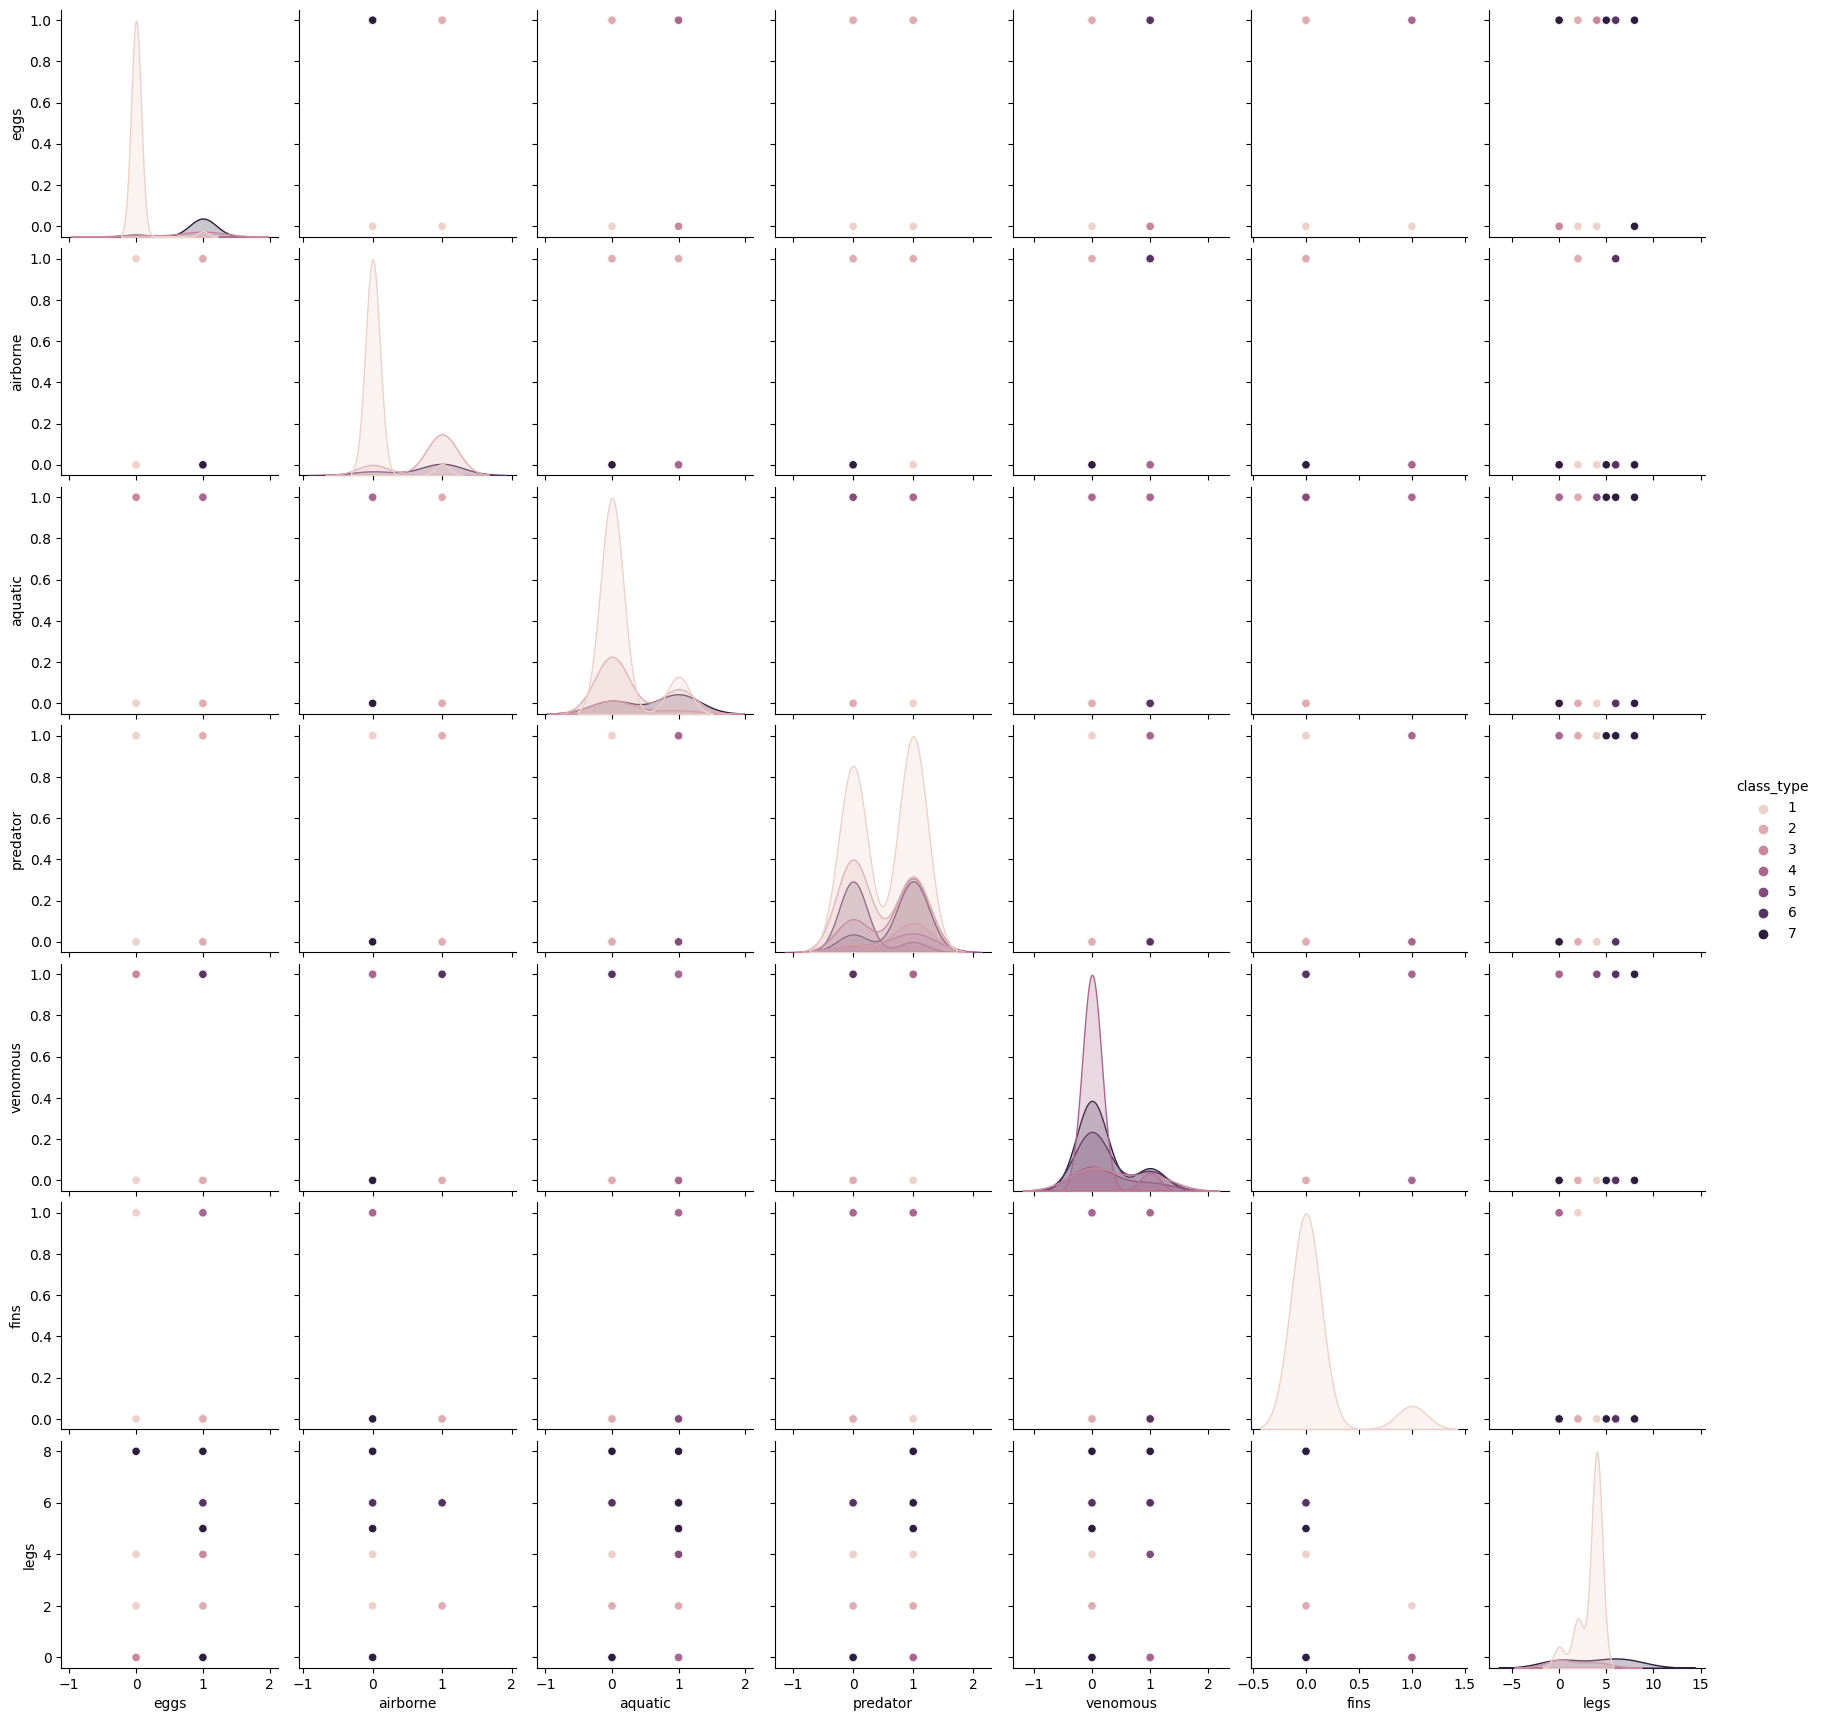

In [30]:
plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':100})

sns.pairplot(df, hue="class_type")
plt.show()

Il dataset non presenta elementi nulli, procedo mostrando una matrice di correlazione delle variabile visualizzando la correlazione della variabile una volta sola

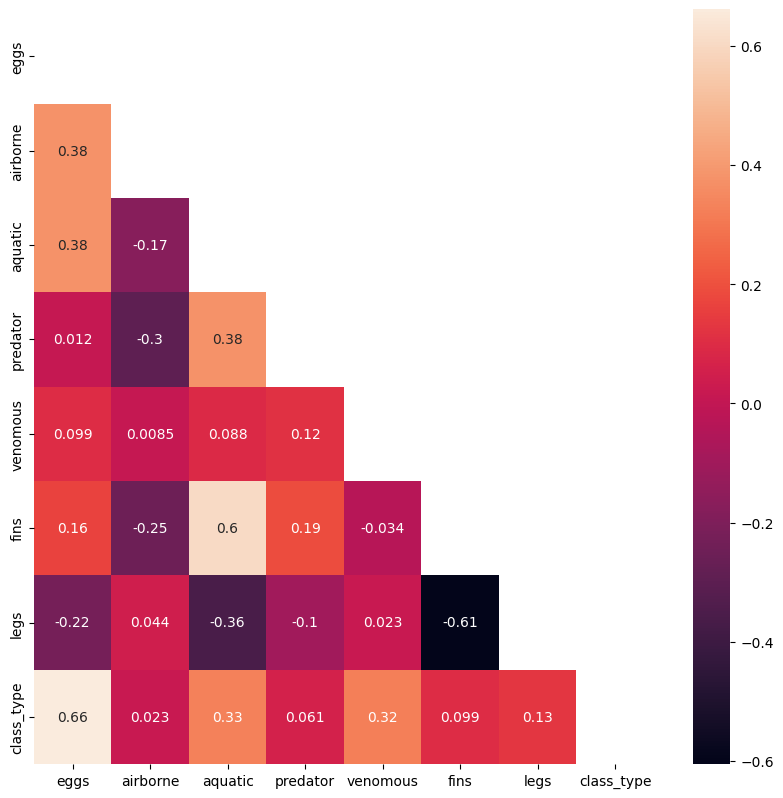

In [31]:
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':100})
sns.heatmap(df.corr(), annot=True, mask=mask)
plt.show()

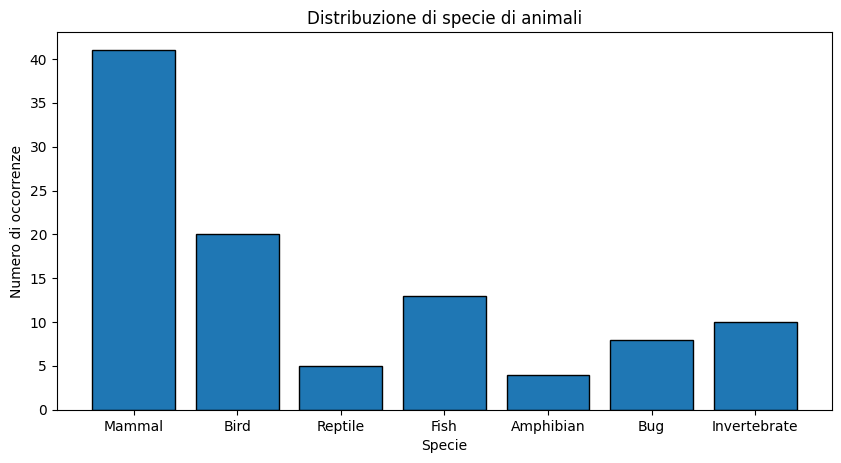

In [32]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':100})
plt.title('Distribuzione di specie di animali')
plt.ylabel('Numero di occorrenze')
plt.xlabel('Specie')
plt.bar(df_class.Class_Type, df_class.Number_Of_Animal_Species_In_Class, edgecolor='black')
plt.show()

In [38]:
# valori di input
X = df.drop(columns=['animal_name','class_type'])
# variabile che voglio predire
y = df['class_type']

<b>PCA - Riduzione della dimensionalità del dataset</b>

Prima di procedere con l'applicazione e l'implementazione del modello mi avvalgo della tecnica della Principal Component Analysis, il cui scopo è quello di ridurre il numero di variabili
che descrivono un insieme di dati ad un numero minore di variabili latenti, in modo da limitare la perdita di informazioni tramite una trasformazione lineare
delle variabili che proietta quelle originarie in un nuovo sistema cartesiano nel quale la nuova variabile con maggiore varianza, viene proiettata sul primo asse, la nuova,
seconda per dimensione della varianza sul secondo asse e così via. Le variabili con varianza maggiore sono quelle che contengono maggiori informazioni di quelle a varianza minore.

Sia $ X $ una matrice $ N \times D $ (con $ N $ numero di dati e $ D $ numero di osservazioni). Ogni riga di $ X $ rappresenta un diverso elemento, ogni colonna di $ D $ una diversa variabile.<br>
Si assuma che ogni colonna di $ X $ abbia media nulla, l'obbiettivo è trovare una matrice $ W $ di dimensioni $ D \times D $ che proietti i dati in un nuovo spazio come segue $ Z = XW $ (è invertibile $ X = ZW^T $)

Dunque, prima di procedere con lo split in training e test set applico la PCA:

In [40]:
from sklearn.decomposition import PCA
# X_reduced because is reduced after PCA decomposition
X_red = PCA().fit_transform(X,y)

# print(X_red , type(X_red) , len(X_red), len(X_red[0]))

Prima di applicare il modello visualizzo i dati ridotti in uno scatterplot.

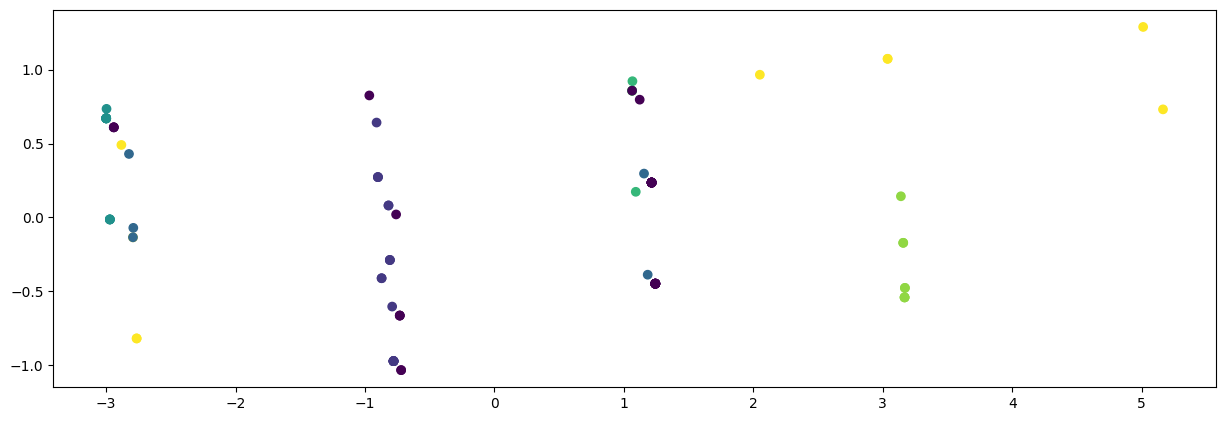

In [43]:
plt.rcParams.update({'figure.figsize':(15,5), 'figure.dpi':100})
plt.scatter(x=X_red[:,0], y=X_red[:,1], c=df['class_type'])
plt.show()

I dati dopo l'applicazione della PCA risultano aggregati tra loro. Con questi informazioni, so già a prescindere che un modello KNN sarà valido. Decido di implementare 4 modelli e verificare quale di questi performa meglio.
In ordine saranno applicati

- Regressione Lineare
- Alberi Decisionali
- Random Forest
- KNN

Prima di tutto divido il dataset in training_set e test_set. Per valutare le performance dei modelli mi avvalgo di una matrice di confusione. Può essere definita, per un classificatore su N classi, come matrice C di dimensione $ N \times N $ in cui l'elemento generale $ C_{ij} $ è pari al numero di osservazioni appartenenti alla classe i predetti come appartenenti alla classe $ j $

I numeri della matrice vanno interpretati considerando la numerosità delle classi e possono essere difficili da leggere, per ovviare questo problema è possibile normalizzare la matrice dividendo ogni elemento $ C_{ij} $ per $ C_{ij} = \sum_j C_{ij} $

In [53]:
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.25)
print("Dimensione training set %d, dimensione test set %d" % (len(X_train), len(X_test)))

Dimensione training set 75, dimensione test set 26


Regressione lineare: algoritmo supervised il cui output predetto ha un valore $ \in R $. A partire da una variabile indipendente $ X $ si vuole predire $ Y $ <br>

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon  $$

(train) accuracy score: 0.9820537842768811
(test) accuracy score: 0.971111893096525


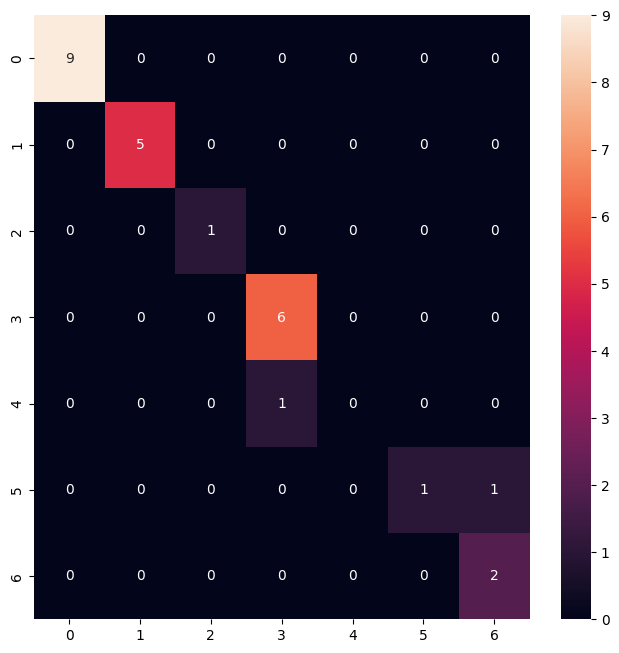

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print(f"(train) accuracy score: {lr_model.score(X_train, y_train)}")
y_pred = lr_model.predict(X_test)
lr_score = lr_model.score(X_test, y_test)
print(f"(test) accuracy score: {lr_score}")
y_pred = np.round(y_pred).astype(int)

plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':100})
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), annot=True)
plt.show()

<b>Alberi decisionali</b>: algoritmo supervisionato usato per risolvere problemi di classificazione e regressione le cui funzioni di classificazione sono apprese sotto forma di un albero dove:
- un nodo interno rappresenta una variabile
- un arco verso un nodo figlio rappresenta un possibile valore per quella proprietà
- una foglia rappresenta il valore predetto per la classe a partire dai valori delle altre proprietà che nell’albero è rappresentato dal cammino (PATH) al nodo radice (ROOT) e dal nodo foglia.

In questo caso un problema di classificazione può essere visto come un problema di partizione dello spazio degli attributi in zone di influenza assegnate alla classe che si vuole individuare.

Dato un training set etichettato $ S_0 $ e con soglia fissata $ T $ si misura con l'impurezza di $ S_0 $ con uno dei seguenti criteri:<br>
<b>Entropia di Shannon</b>: $ E = f_1 log (f_1) + \dots + f_n log (f_n) , f_i = \frac{n_i}{N} \forall i = 1 \dots h $ <br>
<b>Massima discrepanza</b>: $ M = 1 - max(f_i) $ <br>
<b>Indice di Gini</b>: $ \sum_{ij} k_{ij} \space \space \space i ≠ j $ dove $ k_{ij} = f_i * f_j $ è il prodotto di dutte le frequenze delle classi

Se:
- impurezza < T
    - insieme omogeoneo o,
    - tutti gli elementi di S_0 sono in un'unica classe, oppure
    - ci troviamo in una foglia
- impurezza > T
    - ci troviamo in un nodo interno
    - $ S_0 $ da spezzettare in due parti usando un criterio che produca insiemi mediamente più puri della loro unione

Se il modello è estremamente complesso è probabile che stia fornendo un modello overfitted. È necessario semplificare l'albero accorpando tra loro foglie prossime e simili controllando il livello di approssimazione che verrebbe
così introdotto, facendo uso di un Control Set che stima l'errore di generalizzazione $ E_T $ che si ottiene usando l'albero completo T ottenuto al termine della procedura ricorsiva. Si considerano gli errori di generalizzazione $ ( T_1 \dots T_p ) $
unendo di volta in volta gruppi di foglie. Se il minimo errore di generalizzazione è minore a $ E_T $ o non aumenta tale valore di una quantità stabilita a priori, si sostituisce T con il $ T_i $ corrispondente e si tenta ricorsivamente un altro passo
di potatura finché l'errore di generalizzazione non supera una soglia o non può ulteriormente ridursi.

(train) accuracy score: 0.9466666666666667
(test) accuracy score: 0.9230769230769231


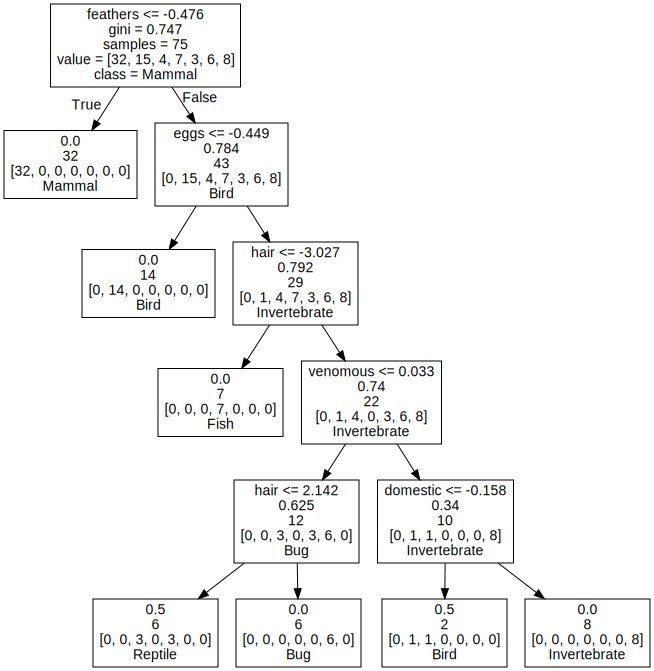

In [43]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#limitiamo la profondità massima dell'albero per poterlo visualizzare in seguito
dt_model = DecisionTreeClassifier(max_depth=5)
dt_model.fit(X_train, y_train)
print(f"(train) accuracy score: {dt_model.score(X_train, y_train)}")
dt_score = dt_model.score(X_test, y_test)
print(f"(test) accuracy score: {dt_score}")

#specifichiamo, tra le altre cose, il nomi delle feature e quelli delle classi

dot_data = tree.export_graphviz(dt_model, out_file=None, feature_names=X.columns.values, class_names=df_class.Class_Type.values, rotate=False, label='root')
graph = graphviz.Source(dot_data)
graph

Foreste decisionali: una variazione alla procedura di pruning è costruire, utilizzando il training set, molti alberi di profondità limitata (2 o 3 livelli massimo) ove le soglie per lo splitting siano scelte a caso. Le foglie ottenute sono quindi assegnate alla classe che in esse detiene una decisa maggioranza. Se non c’è una chiara maggiorazione la foglia resta grigia. Quando si presenta un record da classificare viene passato a ciascun albero della foresta e ciascun albero darà un responso circa la classe a cui viene attribuito. Tale procedura si conclude assegnando al record l’etichetta più votata.

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=3, n_jobs=-1)

rf_model.fit(X_train, y_train)
print(f"(train) accuracy score: {rf_model.score(X_train, y_train)}")
rf_score = rf_model.score(X_test, y_test)
print(f"(test) accuracy score: {rf_score}")

(train) accuracy score: 0.9866666666666667
(test) accuracy score: 0.9615384615384616


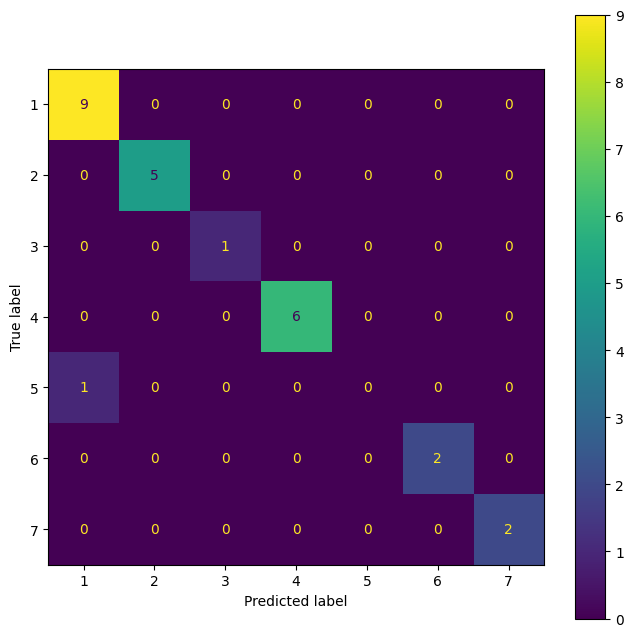

In [45]:
plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':100})
plot_confusion_matrix(rf_model, X_test, y_test.values)
plt.show()

<b>KN Neighbor</b>: ogni record di un insieme di dati può essere interpretato come un punto in uno spazio geometrico. Se a tale spazio si assegna una funzione di distanza, questa potrò essere interpretata come misura della dissimilarità tra i vari record. A partire da questa idea e grazie alla flessibilità del concetto di distanza ( o metrica) è possibile catturare le vicinanze (in senso semantico) tra i vari record.<br>
Dato un training set S etichettato con due classi $ C_1 $ e $ C_2 $ . Sia $P$ un nuovo record da classificare.
Si trovino in $S$ i k punti che abbiano distanza minima da $P$.
Si assegni $P$ alla classe che risulta maggiormente rappresentata tra i k vicini più prossimi a $P$ che sono stati così trovati. (Algoritmo KNN)
Si preferisce sempre scegliere un valore k dispari in modo da avere sempre una maggioranza definita. In alcuni casi si richiede che la maggioranza sia almeno di un $(50+T)%$ con valori di T tali da assicurare “robustezza”. In tal caso quando non si ha una maggioranza “qualificata” il punto $P$ resta non classificato.

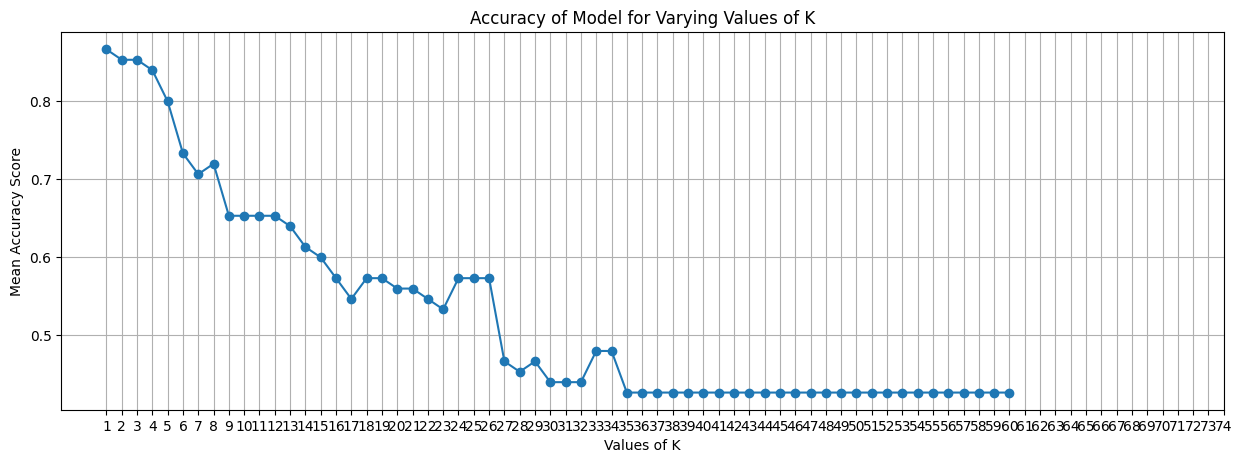

In [63]:
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore") # suppress warning

# Get score for different values of n
k_list = np.arange(1, len(X_train))
mean_scores = []
accuracy_list = []
error_rate = []

for i in k_list:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    score = cross_val_score(knn,X_train, y_train)
    mean_scores.append(np.mean(score))
    error_rate.append(np.mean(pred_i != y_test))

# Plot n values and average accuracy scores
plt.plot(k_list,mean_scores, marker='o')

plt.rcParams.update({'figure.figsize':(12, 5), 'figure.dpi':100})
# Added titles and adjust dimensions
plt.title('Accuracy of Model for Varying Values of K')
plt.xlabel("Values of K")
plt.ylabel("Mean Accuracy Score")
plt.xticks(k_list)
plt.grid()
plt.show()

In [48]:
from sklearn.model_selection import GridSearchCV
#definiamo la griglia di parametri.
param_grid = [ {'n_neighbors':range(1,50)}]
#definiamo l'oggetto Grid Search
gs = GridSearchCV(KNeighborsClassifier(), param_grid)
#avviamo la ricerca.
gs.fit(X_train, y_train)
best_knn = gs.best_estimator_
print("Migliore valore di K trovato utilizzando solo il training set: %d" % best_knn.n_neighbors)

Migliore valore di K trovato utilizzando solo il training set: 1


In [49]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train,y_train)
print(f"(train) accuracy score: {knn_model.score(X_train, y_train)}")
knn_score = knn_model.score(X_test, y_test)
print(f"(test) accuracy score: {knn_score}")

(train) accuracy score: 1.0
(test) accuracy score: 1.0


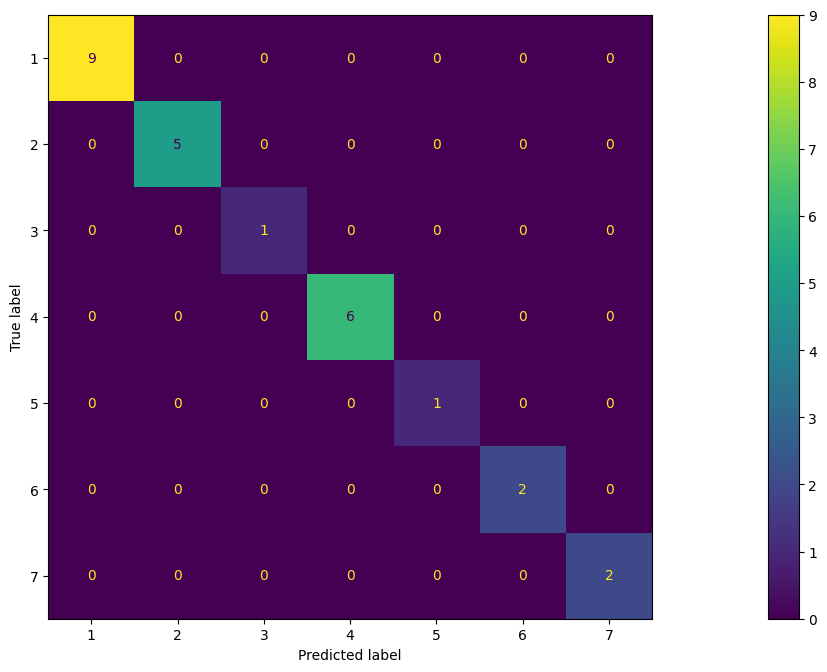

In [50]:
plot_confusion_matrix(knn_model, X_test, y_test.values)
plt.show()

Verifico qual è il migliore algoritmo con un grafico a barre:

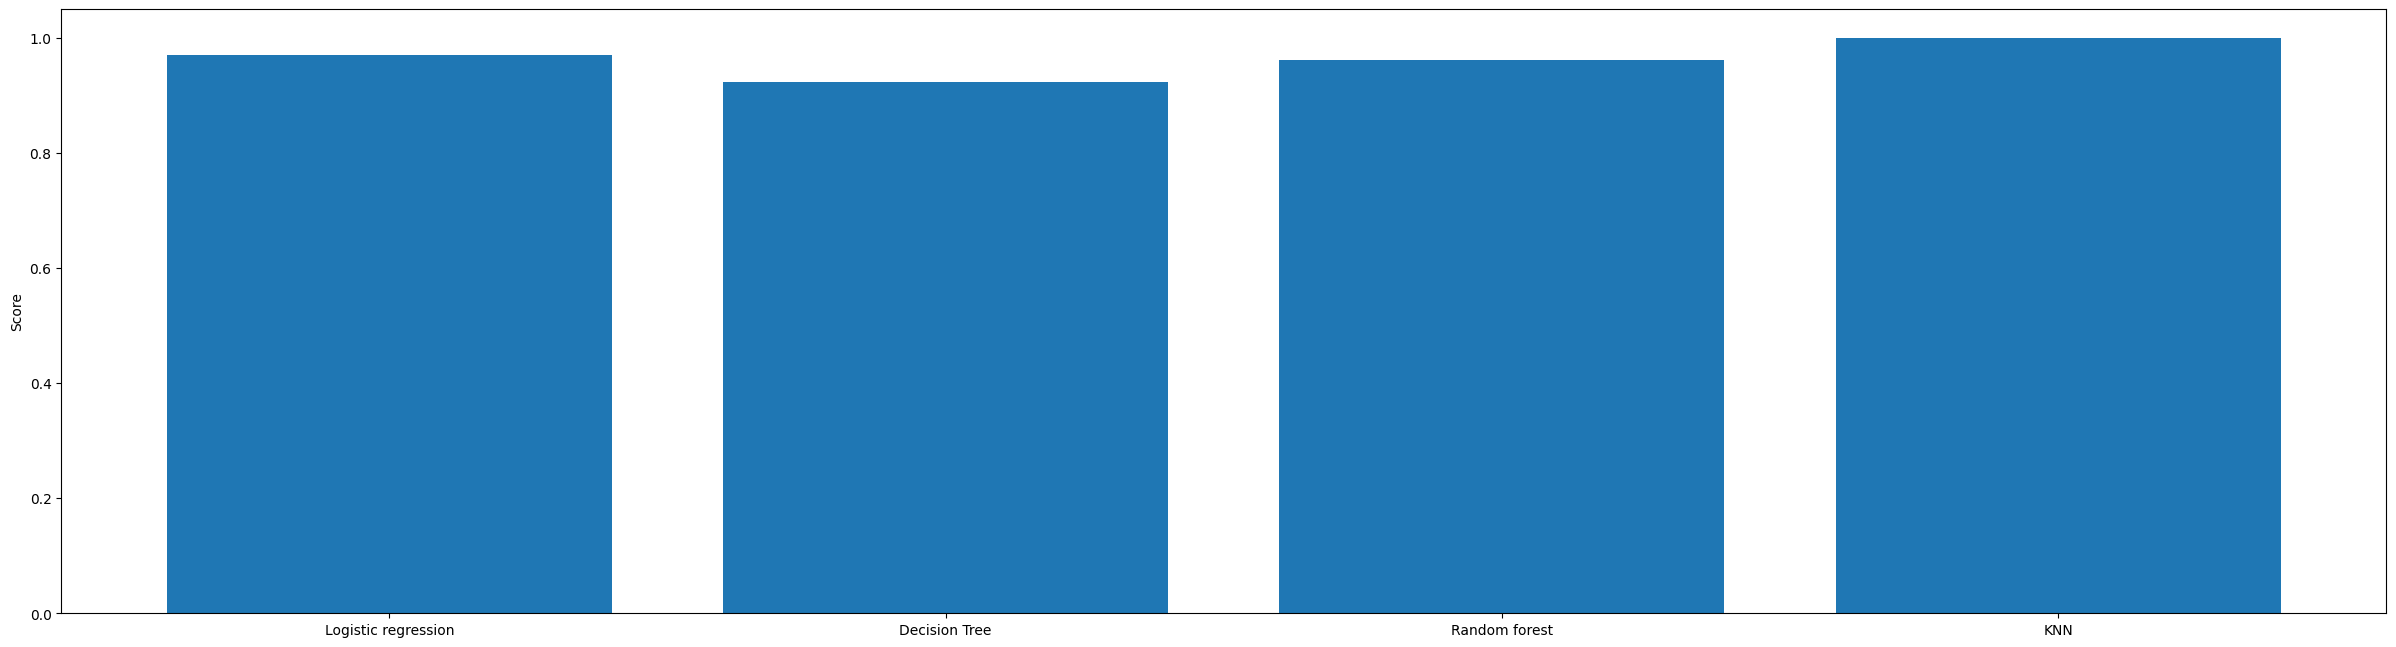

In [51]:
x = np.arange(4)

scores = np.array([ lr_score, dt_score, rf_score, knn_score ])


plt.bar(x, scores)
plt.xticks(x, ('Logistic regression', 'Decision Tree', 'Random forest', 'KNN'))
plt.ylabel(ylabel='Score')
plt.show()